## Exploratory Data Anaylsis

File downloaded from:
https://www.kaggle.com/competitions/seti-breakthrough-listen/data/train/0/0000799a2b2c42d.npy

In [49]:
# !pip install plotly

In [50]:
import os
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir, path
import plotly.express as px

Load training data.

In [51]:
data_dir = r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train'
labels_df = pd.read_csv(os.path.join(data_dir, '_labels.csv'), delimiter=',')

# files = listdir(train_data_dir)

# for f in files:
#     train_data[f.split('.')[0]] = np.load(path.join(train_data_dir, f))

In [52]:
def get_image_path(data_directory, file_id):
    path = os.path.join(data_directory, file_id[0], f'{file_id}.npy')

    return path

In [53]:
def get_image_data(data_directory, file_id):
    file_path = os.path.join(data_directory, file_id[0], f'{file_id}.npy')
        
    if os.path.exists(file_path):
        return np.load(file_path)
    
    return

In [54]:
# train_labels = pd.read_csv(r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train\_labels.csv', delimiter=',')
# train_labels.head()

data_df = labels_df.copy()

# data_df['image_data'] = labels_df['id'].apply(lambda x: get_image_data(data_dir, x))
data_df['file_path'] = labels_df['id'].apply(lambda x: get_image_path(data_dir, x))

In [55]:
data_df.head()

,id,target,file_path
0,0000799a2b2c42d,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
1,00042890562ff68,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
2,0005364cdcb8e5b,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
3,0007a5a46901c56,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
4,0009283e145448e,0,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...


Locate a positive sample so that it can be visualised:

In [56]:
positive_sample = data_df[data_df.target == 1].iloc[22]
positive_sample_images = np.load(positive_sample['file_path']).astype(np.float32)

Explore the shape of the positive samples data:

In [57]:
np.shape(positive_sample_images)

(6, 273, 256)

It consists of a 3D array. Where there are 6 entries of images with resolution 273x256.

Plot in "grayscale":

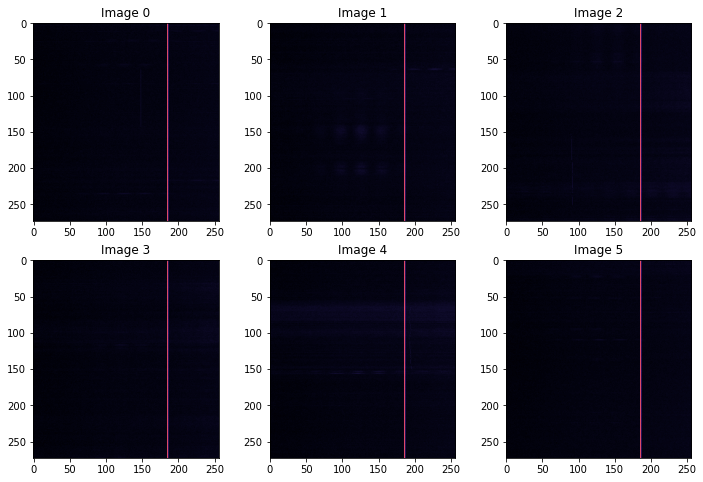

In [58]:
f, ax = plt.subplots(2, 3, figsize=(12,8))

for i in range(len(positive_sample_images)):
    row = i // 3
    column = i - row * 3
    
    ax[row, column].set_title('Image ' + str(i))
    ax[row, column].imshow(positive_sample_images[i], cmap=plt.get_cmap('magma'))

Each data file is a collection of spectograms. There is one spectogram for each 6 stars observed in the sequence **ABACAD**.
Where A is the target star and the rest are nearby off target stars.

### 1st place background noise reduction technique

1. Normalise per column
2. Calculate mean pixel difference of first column to all other images and columns
3. Some column distances are greater than 0 due to possible signals or rounding errors
4. Utilise overlaps to boost S:N ratio, by replacing original data with difference of normed regions between multiple matched samples.
5. Induces shadowing, where difference is <<0, from signals in matched samples. Which models can distinguish from actual signals.

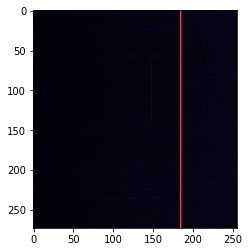

In [59]:
plt.imshow(positive_sample_images[0], cmap=plt.get_cmap('magma'))

In [60]:
image_df = pd.DataFrame(positive_sample_images[0])

image_df.shape

(273, 256)

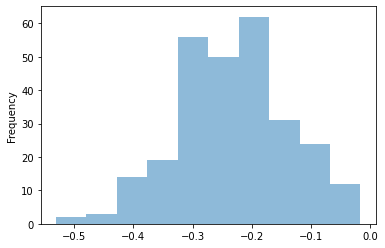

In [61]:
ax = image_df[0].plot.hist(bins=10, alpha=0.5)

In [62]:
'''
min max normalise a df column
'''
def normalise_column(col):
    return (col - col.min()) / (col.max() - col.min())

image_df[0] = normalise_column(image_df[0])

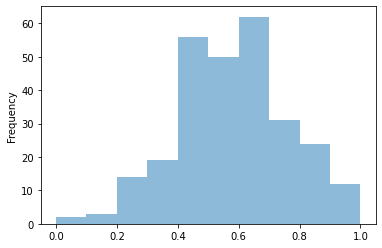

In [63]:
ax = image_df[0].plot.hist(bins=10, alpha=0.5)

In [64]:
image_df = image_df.apply(lambda x: normalise_column(x)) # normalise all columns

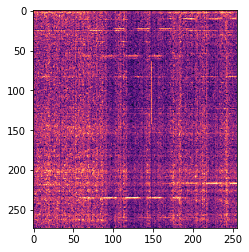

In [81]:
plt.imshow(image_df, cmap=plt.get_cmap('magma'))

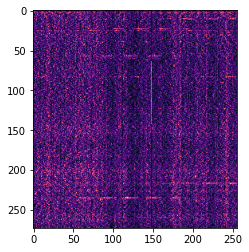

In [173]:
# subtract each column from average of previous 10 columns
denoised_image_df = image_df.copy()
columns_stride = 5

for i in range(columns_stride, image_df.shape[1]):
    previous_columns_sum = pd.Series([0] * len(image_df[0]))

    for j in range(i-columns_stride, i):
        previous_columns_sum = previous_columns_sum + image_df[j]

    previous_columns_average = previous_columns_sum / columns_stride
    denoised_image_df[i] = image_df[i] - previous_columns_average

# denoise first n columns by subtracting the average of the next n columns
for i in range(0, columns_stride):
    following_columns_sum = pd.Series([0] * len(image_df[0]))

    for j in range(i + 1, i + 1 + columns_stride):
        following_columns_sum = following_columns_sum + image_df[j]

    following_columns_average = following_columns_sum / columns_stride
    denoised_image_df[i] = image_df[i] - following_columns_average

# min max normalise between 0 and 1
denoised_image_df = (denoised_image_df - denoised_image_df.min()) / (denoised_image_df.max() - denoised_image_df.min())
denoised_image_df = image_df * denoised_image_df
plt.imshow(denoised_image_df, cmap=plt.get_cmap('magma'))

In [126]:
denoised_image_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.593667,0.223299,0.529184,0.366631,0.577724,0.676229,0.585759,0.543973,0.721104,0.616992,...,0.795116,0.415292,0.021825,0.366220,0.609255,0.482420,0.253321,0.635018,0.601482,0.617272
1,0.590722,0.752109,1.000000,0.532508,0.653826,0.540689,0.278147,0.482223,0.603849,0.307567,...,0.257571,0.356721,0.469487,0.590509,0.522100,0.278165,0.770488,0.387307,0.591860,0.559106
2,0.521919,0.599760,0.186139,0.328770,0.332454,0.749745,0.204674,0.508705,0.244952,0.385823,...,0.725892,0.690071,0.411553,0.518994,0.628584,0.415832,0.450242,0.350672,0.198876,0.471555
3,0.550989,0.659184,0.462546,0.384254,0.498677,0.628150,0.148091,0.391504,0.353666,0.647515,...,0.655335,0.615521,0.505900,0.158538,0.516456,0.555567,0.237163,0.173026,0.300239,0.529990
4,0.464174,0.497461,0.459265,0.628464,0.515373,0.610864,0.592827,0.438301,0.172483,0.267220,...,0.357088,0.742959,0.832195,0.575421,0.454882,0.508955,0.182360,0.412129,0.442353,0.315215


In [68]:
negative_samples = data_df.query('target == 0').sample(n=500)
positive_samples = data_df.query('target == 1').sample(n=500)

train_data_df = negative_samples.append(positive_samples)

C:\Users\adnan\AppData\Local\Temp\ipykernel_11604\1874693528.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data_df = negative_samples.append(positive_samples)


`train_data_df` is now balanced with 500 positive and 500 negative samples:

In [69]:
train_data_df.target.map({0: 'Negative samples', 1: 'Positive samples'}).value_counts()

Negative samples    500
Positive samples    500
Name: target, dtype: int64

Save the balanced training set to file:

In [70]:
save_location = os.path.join(data_dir, '500_balanced_labels.npy')

with open(save_location, 'wb') as f:
    np.save(f, train_data_df)

## Examine generated data:

In [71]:
train_data_df.iloc[0]

id                                             8e09968c49ce4b0
target                                                       0
file_path    D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
Name: 33228, dtype: object

<p style="font-size:30px; color:red; font-weight:bold;">TODO</p>
For the final training run can be done with the full dataset, along with some injected positive samples to balance the dataset.